## Load libraries and Data

In [1]:
# import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json # import json for formatting data
import os # and os for saving
import boto3
import sagemaker
from sagemaker import get_execution_role

In [128]:
features_file = 'data/features.csv'
features_df = pd.read_csv(features_file)

stores_file = 'data/stores.csv'
stores_df = pd.read_csv(stores_file)

test_file = 'data/test.csv'
test_df = pd.read_csv(test_file)

train_file = 'data/train.csv'
train_df = pd.read_csv(train_file)

train_df = train_df.merge(stores_df, how='left').merge(features_df, how='left')
train_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [129]:
# Save as Dataframe the train file and use Date as Index

train_df['Date'] = [datetime.strptime(date, '%Y-%m-%d').date() for date in train_df['Date'].astype(str).values.tolist()]
train_df.index = train_df['Date']
train_df = train_df.drop(['Date'], axis=1)
train_df.sort_values(["Store","Dept"], ascending = (False,False))

train_df.head()

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Date,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
2010-02-12,1,1,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2010-02-19,1,1,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
2010-02-26,1,1,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
2010-03-05,1,1,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


## Convert features to use as dynamical features in DeepAR

In [130]:
def convert_features(train_df):
    # Convert IsHoliday as 1 or 0
    train_df['IsHoliday'] = train_df['IsHoliday'].astype(int)

    # replace store type by numbers 1,2,3
    train_df.Type.replace(['A','B','C'], [1, 2, 3], inplace = True)

    # MarkDown Nan = O, Others = 1
    train_df.fillna(0, inplace=True)
    list=['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
    for i in list:
        train_df.loc[train_df[i] != 0, i] = 1
        
    train_df.replace('NaN', 0, inplace = True)

In [131]:
convert_features(train_df)
train_df.head()

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Date,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,0,1,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
2010-02-12,1,1,46039.49,1,1,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106
2010-02-19,1,1,41595.55,0,1,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106
2010-02-26,1,1,19403.54,0,1,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106
2010-03-05,1,1,21827.90,0,1,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106


In [132]:
# Look at the Store list to see if there are missing numbers
print(train_df.Store.unique())
print(train_df.Store.nunique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
45


In [133]:
# Look at the Dept list to see if there are missing numbers
print(train_df.Dept.unique())
print(train_df.Dept.nunique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 40 41 42 44 45 46 47 48 49 51 52
 54 55 56 58 59 60 67 71 72 74 77 78 79 80 81 82 83 85 87 90 91 92 93 94
 95 96 97 98 99 39 50 43 65]
81


In DeepAR, Categorical features must be encoded as a 0-based sequence of positive integers.  
https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html  
We want a list of 45 Stores and another of 81 Departments, each starting by 0

In [134]:
# Add Cat_Store columns to convert Store to a "Category" field appropriate for DeepAR
train_df['Cat_Store'] = train_df['Store'] - 1

# Add Cat_Dept columns to convert Dept to a "Category" field appropriate for DeepAR
liste = range(81)
for i in liste:
    department = train_df.Dept.unique()[i]
    train_df.loc[train_df['Dept'] == department, 'Cat_Dept'] = int(i)  

train_df.head()

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Cat_Store,Cat_Dept
Date,,,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,0,1,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0,0.0
2010-02-12,1,1,46039.49,1,1,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,0,0.0
2010-02-19,1,1,41595.55,0,1,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,0,0.0
2010-02-26,1,1,19403.54,0,1,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,0,0.0
2010-03-05,1,1,21827.90,0,1,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,0,0.0


In [135]:
# Verify Cat_Store
print(train_df.Cat_Store.unique())
print(train_df.Cat_Store.nunique())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
45


In [136]:
# Verify Cat_Dept
print(train_df.Cat_Dept.unique())
print(train_df.Cat_Dept.nunique())

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78. 79. 80.]
81


In [137]:
# take only 3 stores for first try of training job
train_df = train_df[train_df.Store < 4]
train_df.head()

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Cat_Store,Cat_Dept
Date,,,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,0,1,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0,0.0
2010-02-12,1,1,46039.49,1,1,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,0,0.0
2010-02-19,1,1,41595.55,0,1,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,0,0.0
2010-02-26,1,1,19403.54,0,1,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,0,0.0
2010-03-05,1,1,21827.90,0,1,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,0,0.0


## Plot Sales Evolution

In [138]:
# Define a function to plot sales evolution depending of the store and department number
def sales_evolution(store_number, dept_number):
    example_store_dept_sales = train_df[(train_df.Store == store_number) & (train_df.Dept == dept_number)]['Weekly_Sales']
    plt.figure(figsize=(8,3))
    example_store_dept_sales.plot(title='Store {} Dpt {} Sales evolution'.format(store_number, dept_number), color='blue') 
    return plt.show()

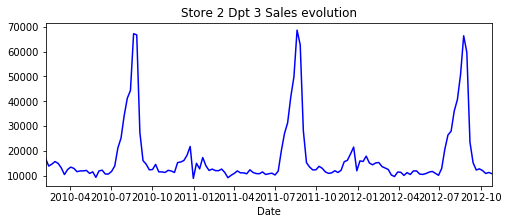

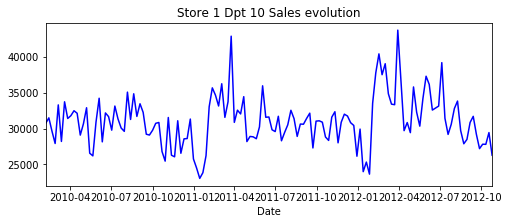

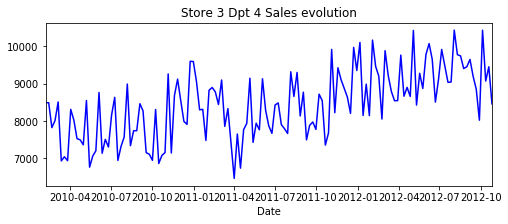

In [139]:
# Plot some examples
sales_evolution(2,3)
sales_evolution(1,10)
sales_evolution(3,4)

## Create and display complete time series

In [140]:
def make_dyn_feat(df, features, years, freq='W-FRI'):
    '''Create dynamic_features for each stores, each years and each selected features
      :param df: dataframe with train data. Contain at least the selected features in columns and Store number
          This dataframe should also be indexed by a datetime.
      :param features : list of choosen dynamical features, evolving over time
      :param years: A list of years to make time series out of, ex. ['2010', '2011'].
      :param freq: The frequency of data recording (W-FRI = Weekly, starting on Friday)
      :return: A 3 dimensional list : Store / year / features
      '''

    # instantiate dynamic features list
    dynamic_feat = []
    
    # create dynamic feature for each store 
    for store in df.Cat_Store.unique().tolist():
        
        # instantite store list
        store_feat=[]
        
        # select features columns and filter on store number.
        # choose one Dept to have only one line for each date
        # Dynamic features are linked to the store, not the departments
        dyn_df = df.loc[(df.Cat_Store == store) & (df.Cat_Dept == 1), features]
        
        # initialise start_idx
        start_idx = 0
        
        # create dynamic feature for each year in years
        for i in range(len(years)):
            years_feat=[]
            year = years[i]
            end_idx = start_idx+52

            # get wanted sample_df data
            dyn_temp_df = dyn_df[start_idx:end_idx]
            
            for j in features:
                years_feat.append(dyn_temp_df[j].tolist())
            
            if len(years) > 1:
                store_feat.append(years_feat)
                # start next year in loop
                start_idx = end_idx+1
            else:
                store_feat = years_feat
            
        if df['Cat_Store'].nunique() > 1:
            dynamic_feat.append(store_feat)
        else:
            dynamic_feat = store_feat
    return dynamic_feat

In [141]:
# Create yearly time series for our 2 complete years
full_years = ['2010', '2011']
freq='W-FRI' # weekly recordings
features = ['IsHoliday','Unemployment']

#'Unemployment'
#'Fuel_Price'

# make dynamic features
dynamic_features = make_dyn_feat(train_df, features, full_years, freq=freq)

In [142]:
print(dynamic_features)

[[[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0], [8.106, 8.106, 8.106, 8.106, 8.106, 8.106, 8.106, 8.106, 7.808, 7.808, 7.808, 7.808, 7.808, 7.808, 7.808, 7.808, 7.808, 7.808, 7.808, 7.808, 7.808, 7.787000000000001, 7.787000000000001, 7.787000000000001, 7.787000000000001, 7.787000000000001, 7.787000000000001, 7.787000000000001, 7.787000000000001, 7.787000000000001, 7.787000000000001, 7.787000000000001, 7.787000000000001, 7.787000000000001, 7.837999999999999, 7.837999999999999, 7.837999999999999, 7.837999999999999, 7.837999999999999, 7.837999999999999, 7.837999999999999, 7.837999999999999, 7.837999999999999, 7.837999999999999, 7.837999999999999, 7.837999999999999, 7.837999999999999, 7.837999999999999, 7.742000000000001, 7.742000000000001, 7.742000000000001, 7.742000000000001]], [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,

In [144]:
def make_time_series(df, years, freq='W-FRI'):
    '''Creates as many time series as they are stores x departments x complete years. 
      :param df: dataframe with train data. One 3 columns : Store, Dept, Weekly_Sales.
          This dataframe should also be indexed by a datetime.
      :param years: A list of years to make time series out of, ex. ['2010', '2011'].
      :param freq: The frequency of data recording (W-FRI = Weekly, starting on Friday)
      :return: A list of pd.Series(), time series data.
      '''
    
    # store time series
    time_series = []
    
    # create time series for each store and each department
    for store in df.Cat_Store.unique().tolist():
        for dept in df.Cat_Dept.unique().tolist():
            
            # create DataFrame with weekly_sales for the store and department studied
            sample_df = df[(df.Cat_Store == store) & (df.Cat_Dept == dept)]['Weekly_Sales']   
            
            # initialise start_idx
            start_idx = 0
            
            # create time series for each year in years
            for i in range(len(years)):

                # for each year 52 weeks (no year of 53 weeks in our dataset)
                year = years[i]
                end_idx = start_idx+52

                # create start and end datetimes
                t_start = year + '-02-05' # start with first date 
                t_end = str(int(year)+1) + '-01-28' # end friday one year later

                # get wanted sample_df data
                data = sample_df[start_idx:end_idx]
                
                # create time series for the year
                index = pd.date_range(start=t_start, end=t_end, freq=freq)
                Serie_df = pd.Series(data=data, index=index)
                
                # include info of the store and dept as last values to use as category in DeepAR
                Info_df = pd.Series(data=[int(store), int(dept)], index=['store','dept'])
                time_series.append(pd.concat([Serie_df, Info_df]))
                
                # start next year in loop
                start_idx = end_idx+1                
    
    # return list of time series
    return time_series

In [145]:
# Create yearly time series for our 2 complete years
full_years = ['2010', '2011']
freq='W-FRI' # weekly recordings

# make time series
time_series = make_time_series(train_df, full_years, freq=freq)

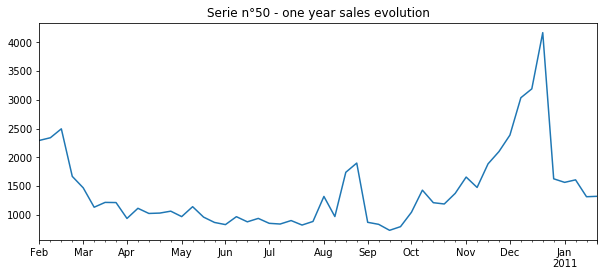

In [151]:
# display first time series
time_series_idx = 50

# plot time series except the last two values corresponding to store and department
plt.figure(figsize=(10,4))
time_series[time_series_idx][:-2].plot(title='Serie n°{} - one year sales evolution'.format(time_series_idx))
plt.show()

## Splitting in Time

In [152]:
# create truncated, training time series
def create_training_series(complete_time_series, prediction_length):
    '''Given a complete list of time series data, create training time series.
       :param complete_time_series: A list of all complete time series.
       :param prediction_length: The number of points we want to predict.
       :return: A list of training time series.
       '''
    # get training series
    time_series_training = []
    
    for ts in complete_time_series:
        
        # save store and departement number for the serie as Info
        Info_df = ts[-2:]
        
        # truncate "prediction_length" weeks + 2 corresponding to the store and departement number
        truncate = prediction_length + 2
        Train_Serie_df = ts[:-truncate]
        
        # save Train_Serie with its Info
        time_series_training.append(pd.concat([Train_Serie_df, Info_df]))
        
    return time_series_training

In [153]:
# set prediction length
prediction_length = 4 # 4 weeks ~ a month

time_series_training = create_training_series(time_series, prediction_length)

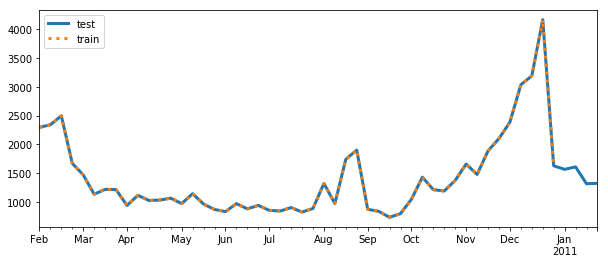

In [154]:
# display train/test time series
time_series_idx = 50

plt.figure(figsize=(10,4))
# test data is the whole time series
time_series[time_series_idx][:-2].plot(label='test', lw=3)
# train data is all but the last prediction pts
time_series_training[time_series_idx][:-2].plot(label='train', ls=':', lw=3)

plt.legend()
plt.show()

## Convert to JSON

In [155]:
def series_to_json_obj(ts, dynamic_feat):
    '''Returns a dictionary of values in DeepAR, JSON format.
       :param ts: A single time series.
       :return: A dictionary of values with "start" and "target" keys.
       '''
    # get start time and target and cat from the time series, ts
    target = list(ts[:-2])
    no_nan_target = pd.Series(target).fillna(0).tolist()
    
    # get dynamic_feat related to the store and the year (same dynamic_feat for all department of one store)
    store = int(ts[-2])
    
    #select year from index
    year = str(ts.index[0])[0:4]
    if year == '2010':
        serie = 0
    else:
        serie = 1
    
    json_obj = {"start": str(ts.index[0]),
                "target": no_nan_target,
                "cat": list(map(int, ts[-2:])),
                "dynamic_feat": dynamic_features[store][serie]
               }
    return json_obj

In [170]:
# test out the code
ts = time_series[202]

json_obj = series_to_json_obj(ts,dynamic_features)

print(json_obj)

{'start': '2010-02-05 00:00:00', 'target': [16827.5, 19286.0, 17803.75, 13153.25, 14656.5, 16055.25, 17283.75, 16632.75, 20982.5, 21236.25, 17095.5, 16876.0, 16576.5, 27799.0, 15107.25, 17035.25, 17879.25, 19886.75, 18220.0, 16997.5, 17223.0, 15389.5, 14617.75, 12375.83, 13264.0, 14486.65, 14768.0, 14424.98, 17355.76, 18175.92, 13813.27, 14026.13, 12650.03, 12821.48, 13783.66, 14718.65, 12614.9, 14434.14, 15303.68, 17019.23, 15578.51, 16927.86, 18878.98, 15601.15, 22285.19, 20580.15, 30205.63, 11574.68, 10612.29, 13163.69, 11978.96, 9782.15], 'cat': [1, 23], 'dynamic_feat': [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0], [8.324, 8.324, 8.324, 8.324, 8.324, 8.324, 8.324, 8.324, 8.2, 8.2, 8.2, 8.2, 8.2, 8.2, 8.2, 8.2, 8.2, 8.2, 8.2, 8.2, 8.2, 8.099, 8.099, 8.099, 8.099, 8.099, 8.099, 8.099, 8.099, 8.099, 8.099, 8.099, 8.099, 8.099, 8.163, 8.163, 8.163, 8.163, 8.163, 8.163, 8.163

## Saving Data, Locally

In [174]:
def write_json_dataset(time_series, filename): 
    with open(filename, 'wb') as f:
        # for each of our times series, there is one JSON line
        for ts in time_series:
            json_line = json.dumps(series_to_json_obj(ts,dynamic_features)) + '\n'
            json_line = json_line.encode('utf-8')
            f.write(json_line)
    print(filename + ' saved.')

In [175]:
# save this data to a local directory
data_dir = 'json_sales_data_dyn'

# make data dir, if it does not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [176]:
# directories to save train/test data
train_key = os.path.join(data_dir, 'train.json')
test_key = os.path.join(data_dir, 'test.json')

# write train/test JSON files
write_json_dataset(time_series_training, train_key)        
write_json_dataset(time_series, test_key)

json_sales_data_dyn/train.json saved.
json_sales_data_dyn/test.json saved.


## Uploading data to S3

In [37]:
# session, role, bucket
sagemaker_session = sagemaker.Session()
role = get_execution_role()
bucket = sagemaker_session.default_bucket()

In [38]:
# general prefix
prefix='deepar-weekly-sales'

# *unique* train/test prefixes
train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix    = '{}/{}'.format(prefix, 'test')

# uploading data to S3, and saving locations
train_path  = sagemaker_session.upload_data(train_key, bucket=bucket, key_prefix=train_prefix)
test_path   = sagemaker_session.upload_data(test_key,  bucket=bucket, key_prefix=test_prefix)

In [39]:
# check locations
print('Training data is stored in: '+ train_path)
print('Test data is stored in: '+ test_path)

Training data is stored in: s3://sagemaker-eu-central-1-293973958717/deepar-weekly-sales/train/train.json
Test data is stored in: s3://sagemaker-eu-central-1-293973958717/deepar-weekly-sales/test/test.json


# Training a DeepAR Estimator

## Instantiate an Estimator

In [40]:
from sagemaker.amazon.amazon_estimator import get_image_uri

image_name = get_image_uri(boto3.Session().region_name, # get the region
                           'forecasting-deepar') # specify image

In [41]:
from sagemaker.estimator import Estimator

# dir to save model artifacts
s3_output_path = "s3://{}/{}/output".format(bucket, prefix)

# instantiate a DeepAR estimator
estimator = Estimator(sagemaker_session=sagemaker_session,
                      image_name=image_name,
                      role=role,
                      train_instance_count=1,
                      train_instance_type='ml.c4.xlarge',
                      output_path=s3_output_path
                      )

## Setting Hyperparameters

In [42]:
freq='W'
context_length=4 # same as prediction_length

hyperparameters = {
    "epochs": "50",
    "time_freq": freq,
    "prediction_length": str(prediction_length),
    "context_length": str(context_length),
    "num_cells": "50",
    "num_layers": "2",
    "mini_batch_size": "128",
    "learning_rate": "0.001",
    "early_stopping_patience": "10"
}

In [43]:
# set the hyperparams
estimator.set_hyperparameters(**hyperparameters)

## Training job

In [44]:
%%time
# train and test channels
data_channels = {
    "train": train_path,
    "test": test_path
}

# fit the estimator
estimator.fit(inputs=data_channels)

2020-06-14 17:19:49 Starting - Starting the training job...
2020-06-14 17:19:51 Starting - Launching requested ML instances......
2020-06-14 17:20:58 Starting - Preparing the instances for training...
2020-06-14 17:21:47 Downloading - Downloading input data
2020-06-14 17:21:47 Training - Downloading the training image.....Arguments: train
[06/14/2020 17:22:32 INFO 140475631793984] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[06/14/2020 17:22:32 I

## Deploy and Create a Predictor¶

In [45]:
%%time

# create a predictor
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    content_type="application/json" # specify that it will accept/produce JSON
)

---------------!CPU times: user 297 ms, sys: 837 µs, total: 298 ms
Wall time: 7min 32s


## JSON Prediction Request
The code below accepts a list of time series as input and some configuration parameters. It then formats that series into a JSON instance and converts the input into an appropriately formatted JSON_input.

In [46]:
def json_predictor_input(input_ts, num_samples=50, quantiles=['0.1', '0.5', '0.9']):
    '''Accepts a list of input time series and produces a formatted input.
       :input_ts: An list of input time series.
       :num_samples: Number of samples to calculate metrics with.
       :quantiles: A list of quantiles to return in the predicted output.
       :return: The JSON-formatted input.
       '''
    # request data is made of JSON objects (instances)
    # and an output configuration that details the type of data/quantiles we want
    
    instances = []
    for k in range(len(input_ts)):
        # get JSON objects for input time series
        instances.append(series_to_json_obj(input_ts[k]))

    # specify the output quantiles and samples
    configuration = {"num_samples": num_samples, 
                     "output_types": ["quantiles"], 
                     "quantiles": quantiles}

    request_data = {"instances": instances, 
                    "configuration": configuration}

    json_request = json.dumps(request_data).encode('utf-8')
    
    return json_request

## Get a Prediction
We can then use this function to get a prediction for a formatted time series  
In the next cell, I'm getting an input time series and known target, and passing the formatted input into the predictor endpoint to get a resultant prediction.

In [66]:
# get all input and target (test) time series
input_ts = time_series_training
target_ts = time_series

# get formatted input time series
json_input_ts = json_predictor_input(input_ts)

# get the prediction from the predictor
json_prediction = predictor.predict(json_input_ts)

# print(json_prediction)

In [71]:
# helper function to decode JSON prediction
def decode_prediction(prediction, encoding='utf-8'):
    '''Accepts a JSON prediction and returns a list of prediction data.
    '''
    prediction_data = json.loads(prediction.decode(encoding))
    prediction_list = []
    for k in range(len(prediction_data['predictions'])):
        prediction_list.append(pd.DataFrame(data=prediction_data['predictions'][k]['quantiles']))
    return prediction_list

In [72]:
# get quantiles/predictions
prediction_list = decode_prediction(json_prediction)

# should get a list of 4 predictions 
# with corresponding quantile values
print(prediction_list[0])

            0.1           0.9           0.5
0  25523.765625  45610.218750  36753.925781
1  23933.851562  50973.898438  35323.253906
2  23627.681641  45957.394531  34226.121094
3  26967.865234  48188.191406  35733.621094


## Display the Results
The quantile data will give us all we need to see the results of our prediction.  
Quantiles 0.1 and 0.9 represent higher and lower bounds for the predicted values.  
Quantile 0.5 represents the median of all sample predictions.

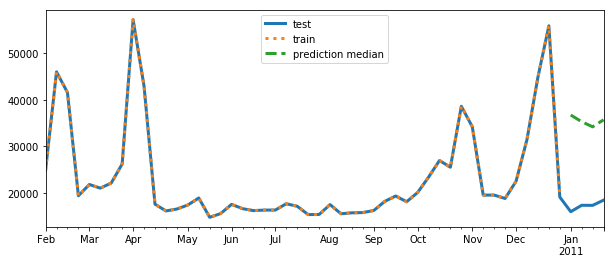

In [68]:
# display train/test time series and prediction median
time_series_idx = 0

pred_df = prediction_list[time_series_idx]['0.5']
pred_df.index = time_series[time_series_idx][-6:-2].index
pred_df

plt.figure(figsize=(10,4))
# test data is the whole time series
time_series[time_series_idx][:-2].plot(label='test', lw=3)
# train data is all but the last prediction pts
time_series_training[time_series_idx][:-2].plot(label='train', ls=':', lw=3)

pred_df.plot(label='prediction median', ls="--", lw=3)

plt.legend()
plt.show()

In [73]:
def display_quantiles(prediction_list, target_ts=None):
    # show predictions for all input ts
    
    # for k in range(len(prediction_list)):
    # len(prediction_list = 1580 for 10 stores so plot only some examples)
    
    for k in range(10):
        plt.figure(figsize=(12,6))
        # get the target month of data
        if target_ts is not None:
            target = target_ts[k][-prediction_length:]
            plt.plot(range(len(target)), target, label='target')
        # get the quantile values at 10 and 90%
        p10 = prediction_list[k]['0.1']
        p90 = prediction_list[k]['0.9']
        # fill the 80% confidence interval
        plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
        # plot the median prediction line
        prediction_list[k]['0.5'].plot(label='prediction median')
        plt.legend()
        plt.show()

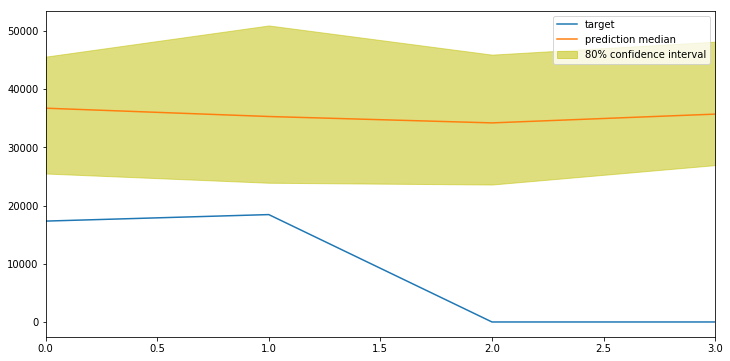

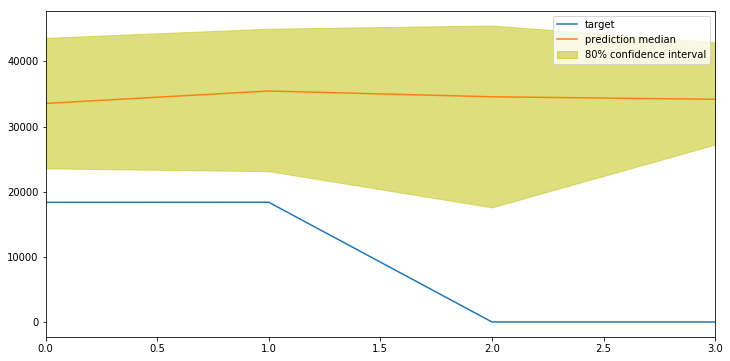

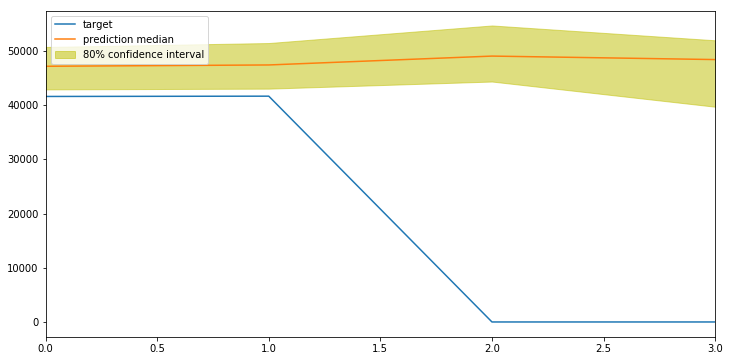

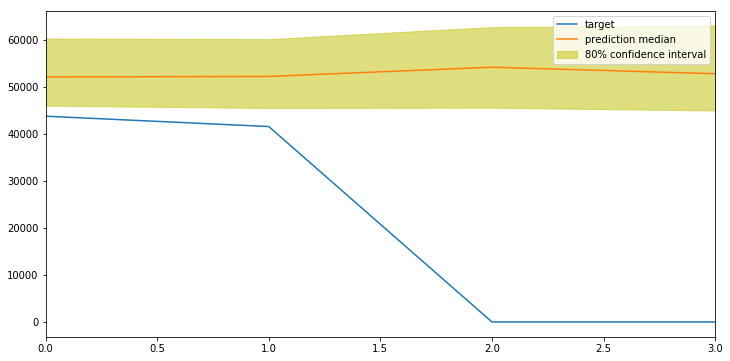

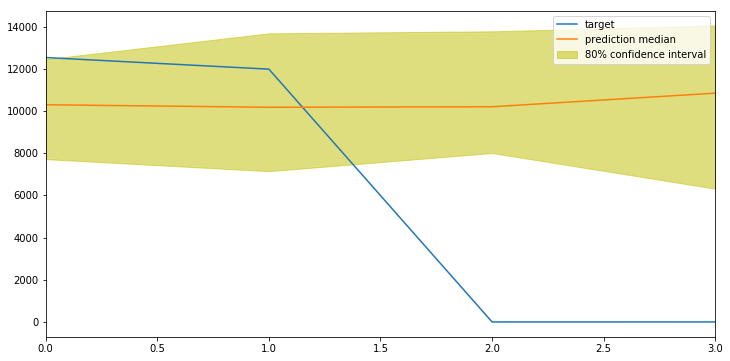

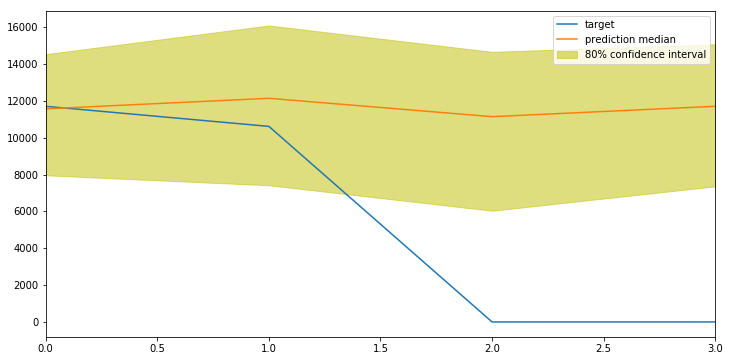

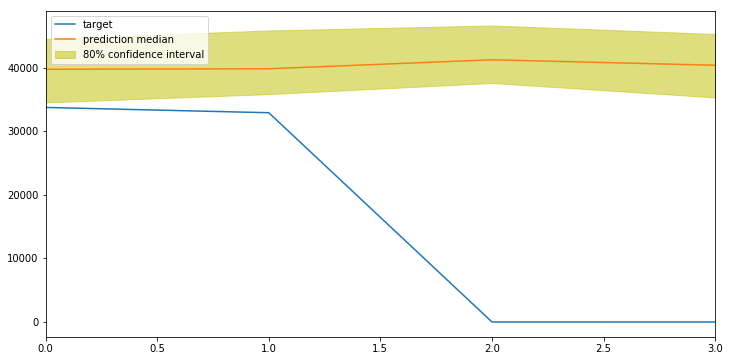

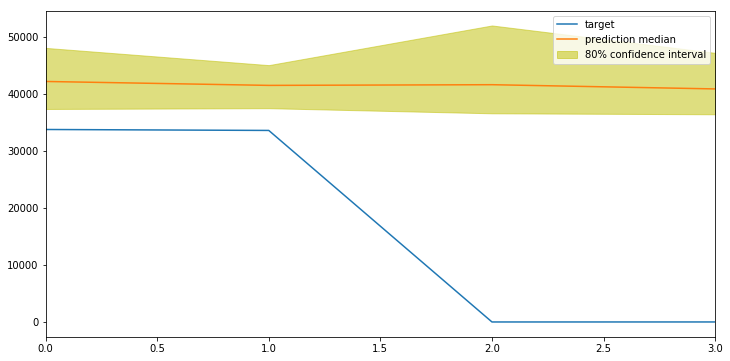

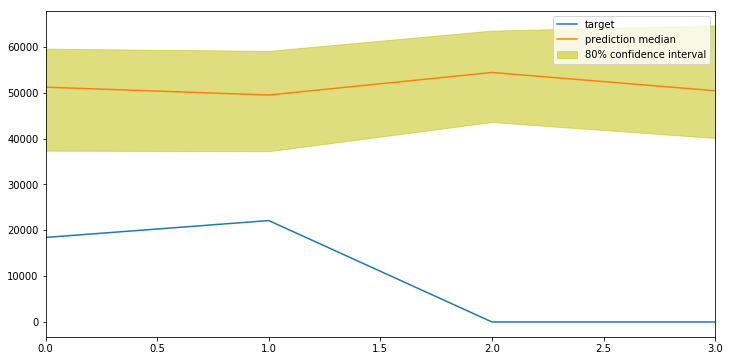

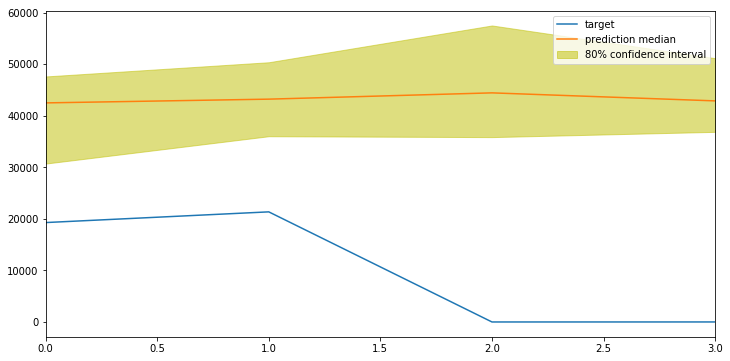

In [74]:
# display predictions
display_quantiles(prediction_list, target_ts)

In [ ]:
# delete the endpoint
predictor.delete_endpoint()